## Fast Agent
Build a SQL Agent fast

In [8]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [9]:
from dataclasses import dataclass

from langchain_community.utilities import SQLDatabase


@dataclass
class RuntimeContext:
    db: SQLDatabase

In [10]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime


@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

In [11]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

In [12]:
from langchain.agents import create_agent

agent = create_agent(
    model="openai:gpt-5",
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

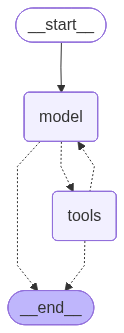

In [13]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [14]:
question = "Which table has the largest number of entries?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which table has the largest number of entries?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_kHzpCyfwdUpYJ3CC7mkFV3ej)
 Call ID: call_kHzpCyfwdUpYJ3CC7mkFV3ej
  Args:
    query: SELECT name FROM sqlite_master WHERE type = 'table' AND name NOT LIKE 'sqlite_%' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_l8NOH6cFKkWKOcXcGUT98eSp)
 Call ID: call_l8NOH6cFKkWKOcXcGUT98eSp
  Args:
    query: SELECT 'Album' AS table_name, COUNT(1) AS row_count FROM Album
UNION ALL
SELECT 'Artist', COUNT(1) FROM Artist
UNION

In [15]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_DlfvgfeRptX29F4XPAokN9Az)
 Call ID: call_DlfvgfeRptX29F4XPAokN9Az
  Args:
    query: SELECT g.Name AS genre_name,
       AVG(t.Milliseconds) AS avg_ms,
       AVG(t.Milliseconds) / 60000.0 AS avg_minutes
FROM genres AS g
JOIN tracks AS t ON t.GenreId = g.GenreId
GROUP BY g.GenreId, g.Name
ORDER BY avg_ms DESC
LIMIT 1;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: genres
[SQL: SELECT g.Name AS genre_name,
       AVG(t.Milliseconds) AS avg_ms,
       AVG(t.Milliseconds) / 60000.0 AS avg_minutes
FROM genres AS g
JOIN tracks AS t ON t.GenreId = g.GenreId
GROUP BY g.GenreId, g.Name
ORDER BY avg_ms DESC
LIMIT 1;]
(Background on this error at: https://sq

In [16]:
question = "What are all the tables?"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What are all the tables?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_i7T2R6FMNtOWehvBl3iKrU9H)
 Call ID: call_i7T2R6FMNtOWehvBl3iKrU9H
  Args:
    query: SELECT name FROM sqlite_master WHERE type = 'table' AND name NOT LIKE 'sqlite_%' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================

Here are the user-defined tables (alphabetical, up to 5 shown). Ask if you want the full list without truncation:
- Album
- Artist
- Customer
- Employee
- Genre

There are more tables available; say “show all” to list them all.


## Let's try this in Studio!